In [13]:
import pandas as pd

df_client = pd.read_csv(r"C:\Users\lenovo\Desktop\CV\vanguard_data\df_final_demo.csv.")
df_client.head()


,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth
0,836976,6.0,73.0,60.5,U,2.0,45105.30,6.0,9.0
1,2304905,7.0,94.0,58.0,U,2.0,110860.30,6.0,9.0
2,1439522,5.0,64.0,32.0,U,2.0,52467.79,6.0,9.0
3,1562045,16.0,198.0,49.0,M,2.0,67454.65,3.0,6.0
4,5126305,12.0,145.0,33.0,F,2.0,103671.75,0.0,3.0


In [ ]:
# Notebook 03 – EDA and KPI Analysis

In this notebook we:
- Explore client demographics (age, gender, balances, tenure, etc.)
- Explore web behaviour and funnel progression
- Compute key KPIs such as completion rate by variation (control vs test)
- Prepare a merged dataset to use later in Tableau

In [14]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Base paths – adjust if your folder is different
BASE = r"C:\Users\lenovo\Desktop\CV\vanguard_data"
CLEAN = os.path.join(BASE, "cleaned_data")

# Load cleaned client and experiment data
client = pd.read_csv(os.path.join(CLEAN, "client_clean.csv"))
experiment = pd.read_csv(os.path.join(CLEAN, "experiment_clean.csv"))

# Load RAW web data parts again (we'll clean steps here for EDA & KPIs)
web1 = pd.read_csv(os.path.join(BASE, "df_final_web_data_pt_1.csv"))
web2 = pd.read_csv(os.path.join(BASE, "df_final_web_data_pt_2.csv"))

web_raw = pd.concat([web1, web2], ignore_index=True)

print("Client shape:", client.shape)
print("Experiment shape:", experiment.shape)
print("Raw web shape:", web_raw.shape)

client.head()


Client shape: (70594, 9)
Experiment shape: (50500, 2)
Raw web shape: (755405, 5)


,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth
0,836976,6,73,60.5,U,2,45105.30,6,9
1,2304905,7,94,58.0,U,2,110860.30,6,9
2,1439522,5,64,32.0,U,2,52467.79,6,9
3,1562045,16,198,49.0,M,2,67454.65,3,6
4,5126305,12,145,33.0,F,2,103671.75,0,3


In [ ]:
## Section 1 – Client Demographics EDA

We explore:
- Age distribution
- Gender breakdown
- Balance distribution
- Number of accounts
- Tenure with Vanguard


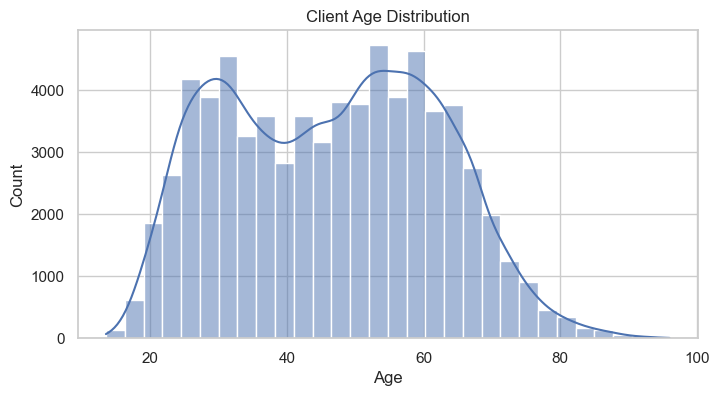

In [17]:



plt.figure(figsize=(8, 4))
sns.histplot(client["clnt_age"], bins=30, kde=True)
plt.title("Client Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

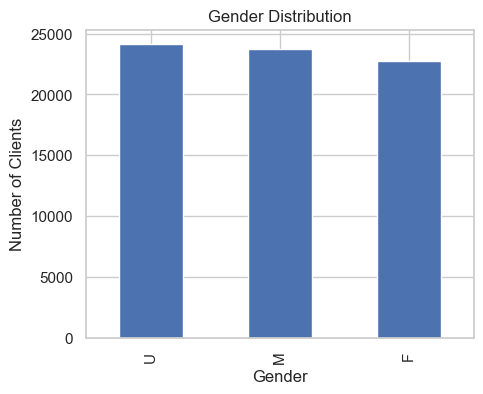

gendr
U    0.341743
M    0.336063
F    0.322195
Name: proportion, dtype: float64

In [18]:
plt.figure(figsize=(5, 4))
client["gendr"].value_counts(dropna=False).plot(kind="bar")
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Number of Clients")
plt.show()

client["gendr"].value_counts(normalize=True)


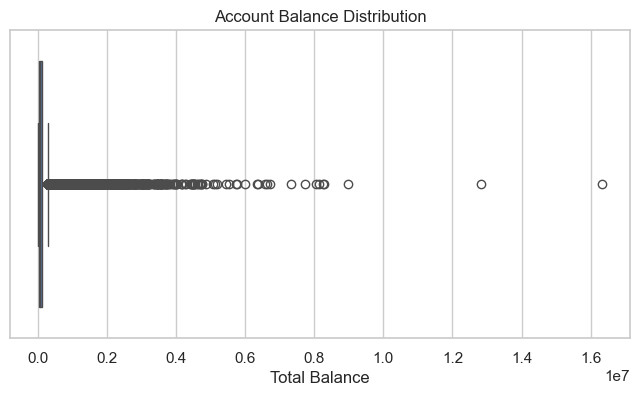

count    7.059400e+04
mean     1.474467e+05
std      3.015106e+05
min      1.378942e+04
25%      3.734660e+04
50%      6.333459e+04
75%      1.375461e+05
max      1.632004e+07
Name: bal, dtype: float64

In [19]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=client["bal"])
plt.title("Account Balance Distribution")
plt.xlabel("Total Balance")
plt.show()

client["bal"].describe()


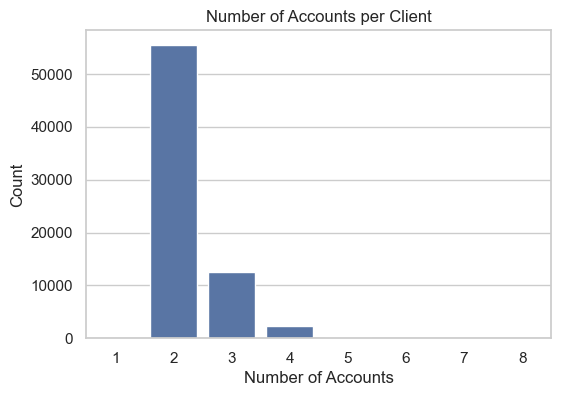

In [20]:
plt.figure(figsize=(6, 4))
sns.countplot(x="num_accts", data=client)
plt.title("Number of Accounts per Client")
plt.xlabel("Number of Accounts")
plt.ylabel("Count")
plt.show()


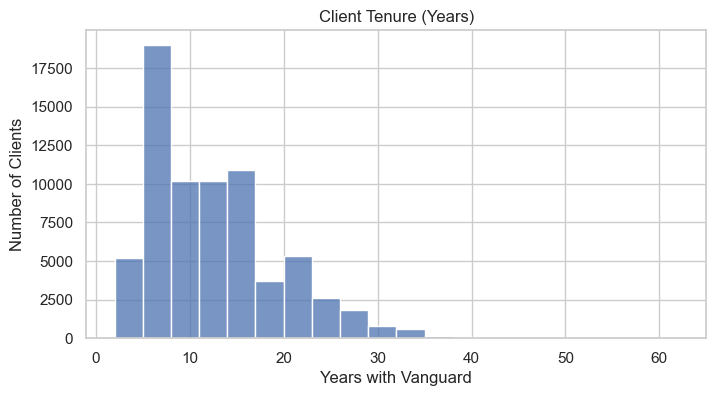

count    70594.000000
mean        12.053007
std          6.871850
min          2.000000
25%          6.000000
50%         11.000000
75%         16.000000
max         62.000000
Name: clnt_tenure_yr, dtype: float64

In [21]:
plt.figure(figsize=(8, 4))
sns.histplot(client["clnt_tenure_yr"], bins=20, kde=False)
plt.title("Client Tenure (Years)")
plt.xlabel("Years with Vanguard")
plt.ylabel("Number of Clients")
plt.show()

client["clnt_tenure_yr"].describe()


In [ ]:
## Section 2 – Web Behaviour and Funnel Exploration

Here we:
- Clean and standardize the process_step information from the web logs
- Look at how many users reach each step
- Compare funnel progression between Control and Test


In [22]:
web = web_raw.copy()

print("Raw web columns:", web.columns.tolist())
print(web.head())

# Keep original step for reference
web["process_step_raw"] = web["process_step"]

# Extract the first number found in the process_step string (e.g. "step_1" -> 1)
web["process_step_num"] = (
    web["process_step_raw"]
    .astype(str)
    .str.extract(r"(\d+)")[0]
)

web["process_step_num"] = pd.to_numeric(web["process_step_num"], errors="coerce")

# Drop rows where we still can't parse a step
web_valid = web.dropna(subset=["process_step_num"]).copy()
web_valid["process_step_num"] = web_valid["process_step_num"].astype(int)

print("Web_valid shape:", web_valid.shape)
print("Unique numeric steps:", sorted(web_valid["process_step_num"].unique()))
web_valid.head()


Raw web columns: ['client_id', 'visitor_id', 'visit_id', 'process_step', 'date_time']
   client_id            visitor_id                      visit_id process_step  \
0    9988021  580560515_7732621733  781255054_21935453173_531117       step_3   
1    9988021  580560515_7732621733  781255054_21935453173_531117       step_2   
2    9988021  580560515_7732621733  781255054_21935453173_531117       step_3   
3    9988021  580560515_7732621733  781255054_21935453173_531117       step_2   
4    9988021  580560515_7732621733  781255054_21935453173_531117       step_3   

             date_time  
0  2017-04-17 15:27:07  
1  2017-04-17 15:26:51  
2  2017-04-17 15:19:22  
3  2017-04-17 15:19:13  
4  2017-04-17 15:18:04  
Web_valid shape: (408497, 7)
Unique numeric steps: [np.int64(1), np.int64(2), np.int64(3)]


,client_id,visitor_id,visit_id,process_step,date_time,process_step_raw,process_step_num
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07,step_3,3
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51,step_2,2
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22,step_3,3
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13,step_2,2
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04,step_3,3


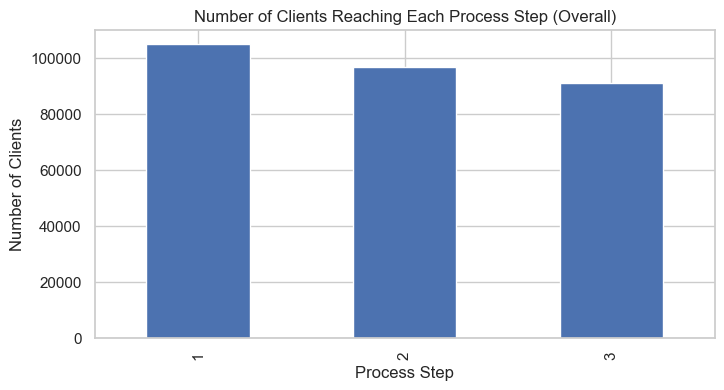

process_step_num
1    104978
2     96943
3     91076
Name: client_id, dtype: int64

In [23]:
# Number of unique clients reaching each step (overall)
funnel_counts = web_valid.groupby("process_step_num")["client_id"].nunique()

plt.figure(figsize=(8, 4))
funnel_counts.plot(kind="bar")
plt.title("Number of Clients Reaching Each Process Step (Overall)")
plt.xlabel("Process Step")
plt.ylabel("Number of Clients")
plt.show()

funnel_counts


In [24]:
# Ensure client_id is numeric and variation is clean
experiment["client_id"] = pd.to_numeric(experiment["client_id"], errors="coerce")
web_valid["client_id"] = pd.to_numeric(web_valid["client_id"], errors="coerce")

experiment = experiment.dropna(subset=["client_id"]).copy()
web_valid = web_valid.dropna(subset=["client_id"]).copy()

experiment["client_id"] = experiment["client_id"].astype("Int64")
web_valid["client_id"] = web_valid["client_id"].astype("Int64")

# Standardize variation
if "Variation" in experiment.columns and "variation" not in experiment.columns:
    experiment = experiment.rename(columns={"Variation": "variation"})

experiment["variation"] = (
    experiment["variation"]
    .astype(str)
    .str.strip()
    .str.lower()
)

experiment = experiment[experiment["variation"].isin(["control", "test"])].copy()

# Merge web + experiment to know which steps belong to which variation
ab = web_valid.merge(
    experiment[["client_id", "variation"]].drop_duplicates(),
    on="client_id",
    how="inner"
)

print("AB merged shape for funnel:", ab.shape)
ab.head()


AB merged shape for funnel: (174000, 8)


,client_id,visitor_id,visit_id,process_step,date_time,process_step_raw,process_step_num,variation
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07,step_3,3,test
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51,step_2,2,test
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22,step_3,3,test
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13,step_2,2,test
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04,step_3,3,test


<Figure size 800x500 with 0 Axes>

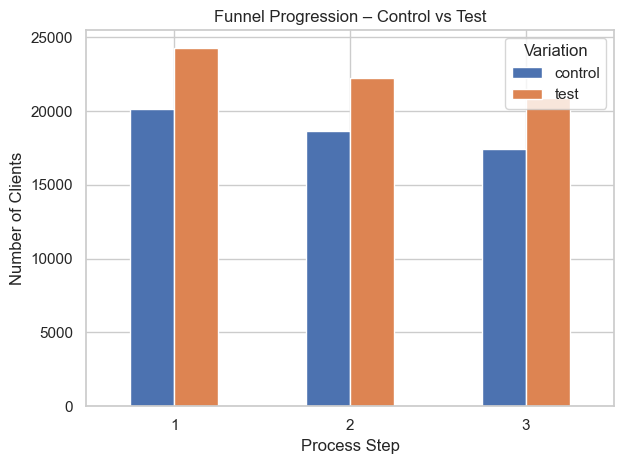

variation,control,test
process_step_num,,
1,20152,24267
2,18650,22258
3,17422,20881


In [26]:
funnel_by_var = (
    ab.groupby(["variation", "process_step_num"])["client_id"]
      .nunique()
      .unstack("variation")
      .fillna(0)
      .astype(int)
)

plt.figure(figsize=(8, 5))
funnel_by_var.plot(kind="bar")
plt.title("Funnel Progression – Control vs Test")
plt.xlabel("Process Step")
plt.ylabel("Number of Clients")
plt.xticks(rotation=0)
plt.legend(title="Variation")
plt.tight_layout()
plt.show()

funnel_by_var


In [ ]:
## Section 3 – KPIs and Completion Rates

Here we:
- Define completion at the client level (reaching the final step)
- Compute completion rate by variation (control vs test)
- Prepare a client-level dataset for Tableau


In [27]:
# Final step in the funnel
final_step = ab["process_step_num"].max()
print("Final numeric process step:", final_step)

# For each client & variation, compute the maximum step they reached
client_level = (
    ab.groupby(["client_id", "variation"], as_index=False)["process_step_num"]
      .max()
      .rename(columns={"process_step_num": "max_step"})
)

# Mark completion
client_level["completed"] = (client_level["max_step"] >= final_step).astype(int)

print("Client-level table shape:", client_level.shape)
client_level.head()


Final numeric process step: 3
Client-level table shape: (44510, 4)


,client_id,variation,max_step,completed
0,555,test,3,1
1,647,test,3,1
2,1028,control,3,1
3,1186,control,2,0
4,1195,control,3,1


In [28]:
completion_summary = client_level.groupby("variation")["completed"].agg(["sum", "count"])
completion_summary["completion_rate"] = completion_summary["sum"] / completion_summary["count"]

print("Completion summary by variation:")
completion_summary


Completion summary by variation:


,sum,count,completion_rate
variation,,,
control,17422,20202,0.862390
test,20881,24308,0.859018


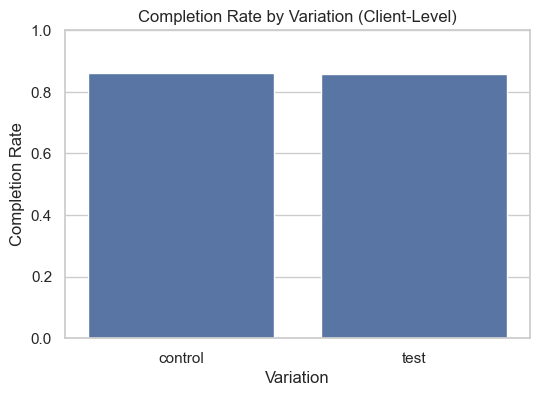

In [29]:
plt.figure(figsize=(6, 4))
sns.barplot(
    x=completion_summary.index,
    y=completion_summary["completion_rate"].values
)
plt.title("Completion Rate by Variation (Client-Level)")
plt.ylabel("Completion Rate")
plt.xlabel("Variation")
plt.ylim(0, 1)
plt.show()


In [30]:
# Join client demographics to client_level so Tableau can slice by age, gender, etc.
client_demo_cols = ["client_id", "clnt_age", "gendr", "num_accts", "bal", "clnt_tenure_yr"]
client_for_join = client[client_demo_cols].drop_duplicates(subset=["client_id"])

client_level_tableau = client_level.merge(
    client_for_join,
    on="client_id",
    how="left"
)

print("Tableau export shape:", client_level_tableau.shape)
client_level_tableau.head()

# Save for Tableau
out_path = os.path.join(BASE, "client_level_for_tableau.csv")
client_level_tableau.to_csv(out_path, index=False)
print("Saved Tableau dataset to:", out_path)


Tableau export shape: (44510, 9)
Saved Tableau dataset to: C:\Users\lenovo\Desktop\CV\vanguard_data\client_level_for_tableau.csv


In [ ]:
## Summary of Notebook 03

- Explored client demographics:
  - Age, gender, balances, number of accounts, and tenure.
- Cleaned and standardized web funnel data using numeric process_step values.
- Built funnel views overall and by variation (control vs test).
- Defined completion at the client level as reaching the final funnel step.
- Computed completion rates by variation using client-level data.
- Exported a client-level dataset (`client_level_for_tableau.csv`) that can be used to build the Tableau dashboard with:
  - Filters by age, gender, accounts, etc.
  - KPIs and completion metrics by experiment variation.
